In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV  
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import roc_curve, auc, roc_auc_score
%matplotlib inline

In [2]:
# Import the data and remove unnecessary columns

df = pd.read_csv('/Users/jack.galvin/Desktop/Predictive/sfdcreport.csv')
df.drop(['Account Name', 'Website', 'Opportunity Name', 'Type', 'Close Date', 'Created Date'], axis = 1, inplace = True)

In [3]:
# Encode 'Closed Won' and 'Sales Order Signed' as 1, 'Closed Lost' as 0

df['Stage'].replace(to_replace = ['Closed Lost', 'Closed Won', 'Sales Order Signed'], value = [0, 1, 1], inplace = True)

In [4]:
# Check for null values to decide on how to impute NaN

df.isna().sum()

Stage                     0
PET Annual Revenue    27469
PET Employees         12872
PET Match Score        8945
$ARR                      0
Age                       0
dtype: int64

In [5]:
df.describe()

,Stage,PET Annual Revenue,PET Employees,PET Match Score,$ARR,Age
count,49150.000000,2.168100e+04,3.627800e+04,40205.000000,4.915000e+04,49150.000000
mean,0.090173,5.981529e+09,9.378244e+03,80.485064,2.946262e+03,89.482930
std,0.286432,2.936147e+10,5.702437e+04,7.901704,2.261256e+04,110.070348
min,0.000000,0.000000e+00,0.000000e+00,19.000000,-3.150000e+04,0.000000
25%,0.000000,4.270000e+06,2.900000e+01,75.000000,0.000000e+00,23.000000
50%,0.000000,4.133000e+07,1.100000e+02,82.000000,0.000000e+00,57.000000
75%,0.000000,8.671300e+08,7.817500e+02,83.000000,0.000000e+00,119.000000
max,1.000000,1.086850e+12,2.200000e+06,100.000000,1.500000e+06,6530.000000


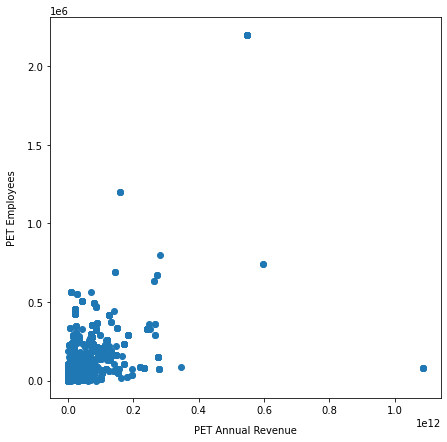

In [6]:
# Scatter plot to visually identify large outliers

plt.figure(figsize = (7,7))
plt.xlabel('PET Annual Revenue', labelpad = 10)
plt.ylabel('PET Employees', labelpad = 10)
plt.scatter(df['PET Annual Revenue'], df['PET Employees']);

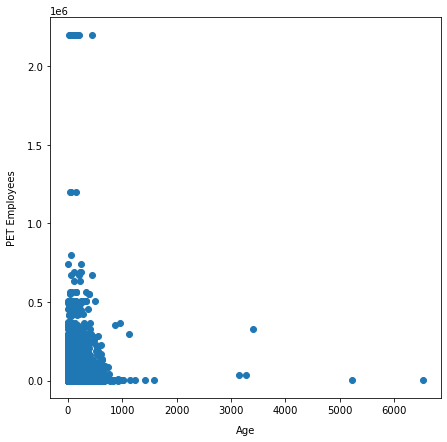

In [7]:
# Scatter plot to visually identify large outliers

plt.figure(figsize = (7,7))
plt.xlabel('Age', labelpad = 10)
plt.ylabel('PET Employees', labelpad = 10)
plt.scatter(df['Age'], df['PET Employees']);

In [8]:
# Remove outliers

df = df[(df['PET Annual Revenue'] < 400000000000) & (df['PET Employees'] < 1000000) & (df['Age'] < 2000)]

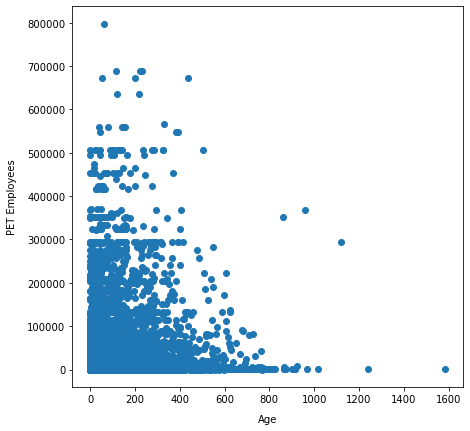

In [9]:
plt.figure(figsize = (7,7))
plt.xlabel('Age', labelpad = 10)
plt.ylabel('PET Employees', labelpad = 10)
plt.scatter(df['Age'], df['PET Employees']);

In [10]:
# Scale data with QuantileTransformer

scaler = QuantileTransformer()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled.head()

,Stage,PET Annual Revenue,PET Employees,PET Match Score,$ARR,Age
0,0.0,0.823863,0.906054,0.034535,0.0,0.693694
1,0.0,0.925936,0.949950,NaN,0.0,0.406406
2,0.0,0.146146,0.041542,0.013514,0.0,0.353353
3,0.0,0.974258,0.926093,0.319319,0.0,0.559059
4,0.0,0.762402,0.753590,0.789289,0.0,0.505005


In [11]:
# Impute using KNNImputer

imputer = KNNImputer(n_neighbors = 15)
df_scaled = pd.DataFrame(imputer.fit_transform(df_scaled),columns = df_scaled.columns)

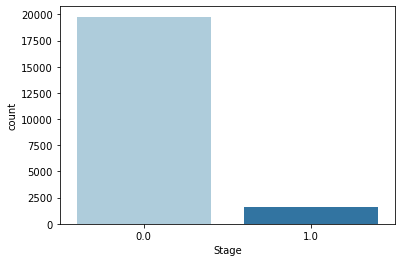

In [12]:
# Data Exploration - Wins and Losses

sns.countplot(x = df_scaled['Stage'], palette = 'Paired');

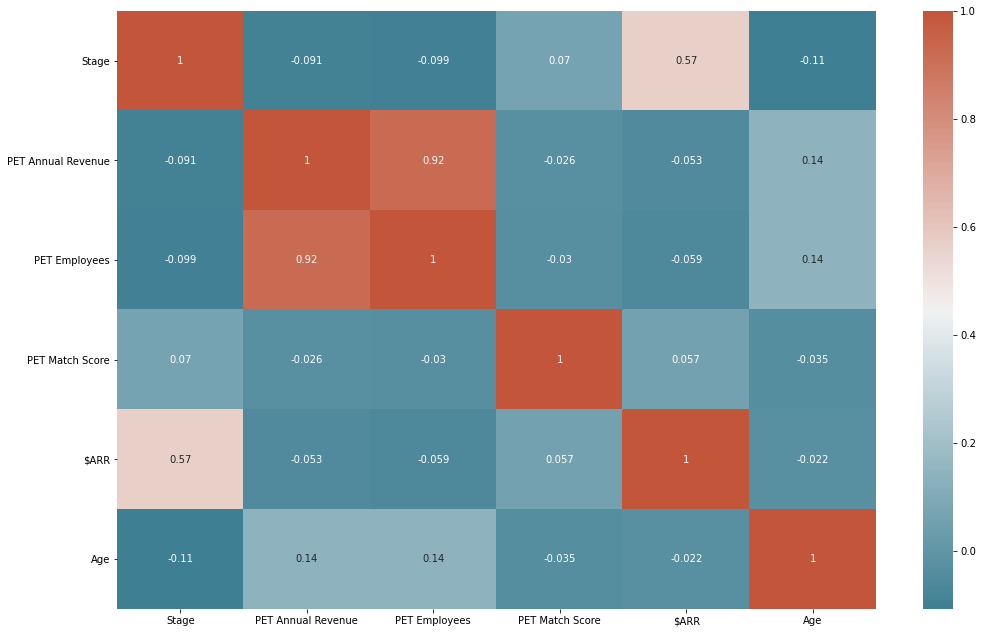

In [13]:
correlation = df_scaled.corr('spearman')
fig, ax = plt.subplots(figsize = (17,11))
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot=True, cmap = sns.diverging_palette(220,20, as_cmap=True), ax=ax);

In [71]:
# Split train and test data

X = df_scaled[['PET Match Score', 'PET Employees', 'PET Annual Revenue', 'Age']]
y = df_scaled['Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42, shuffle = True)

In [82]:
# Implement and fit the model

clf = SVC(kernel = 'linear', probability = True, random_state = 42)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

In [83]:
# Evaluate performance

clf_cv_score = cross_val_score(clf, X, y, cv = 10, scoring = "roc_auc")

In [84]:
# Print out a performance report

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, clf_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, clf_pred))
print('\n')
print("=== All AUC Scores ===")
print(clf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - SVM: ", clf_cv_score.mean())

=== Confusion Matrix ===
[[5886    0]
 [ 523    0]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5886
         1.0       0.00      0.00      0.00       523

    accuracy                           0.92      6409
   macro avg       0.46      0.50      0.48      6409
weighted avg       0.84      0.92      0.88      6409



=== All AUC Scores ===
[0.43773226 0.60716297 0.63289219 0.61931884 0.52071201 0.54795792
 0.59628861 0.51128073 0.6341145  0.45749126]


=== Mean AUC Score ===
Mean AUC Score - SVM:  0.556495129430755


/Users/jack.galvin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


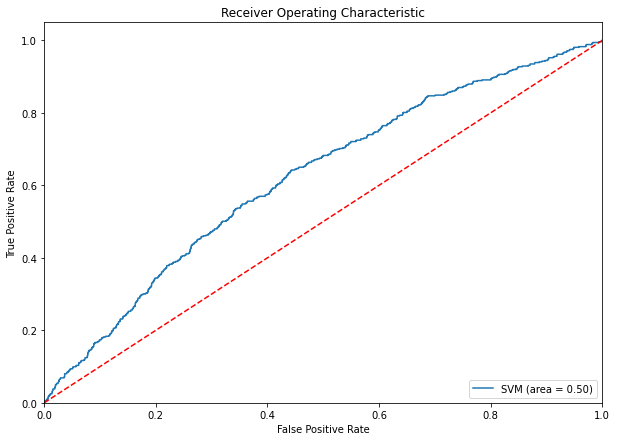

In [85]:
# Plot the ROC Curve

clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()